In [10]:
import  numpy as np
import scipy.linalg as LA
import matplotlib as mpl
import matplotlib.pyplot as plt



from src.noise_design import NoiseDesign
from src.system_model import SystemModel
from src.utils import costume_noise

from src.constant import K, sigma_v, n
from src.constant import (R_min, R_max, M_min, M_max, tav, x0_min, x0_max)


In [11]:
def print_experiment_parameters():
    """
    Prints the system and experiment parameters.
    """
    print(f"Desired privacy set given by :\n {sigma_v}")
    print(f"Number of time steps:\n {K}")
    print(f"Number of states: \n {x_0}")

# System and experiment parameters
print_experiment_parameters()

Desired privacy set given by :
 [[ 16   0   0   0]
 [  0  16   0   0]
 [  0   0 100   0]
 [  0   0   0 100]]
Number of time steps:
 10


In [12]:
# initializing  the  system model class with the parameters in the paper
system_model = SystemModel(n, R_min, R_max, M_min, M_max, tav, x0_min, x0_max, K)


In [13]:

# initializing the Noise Design class with the system parameters and desired time steps 
noise_design = NoiseDesign(system_model.A, system_model.C, K)


In [14]:

# Solve optimization (28) in the paper
status, beta, sigma = noise_design.solve_cvx(sigma_v)

# Here we check whether the we get the noise that we wanted to get:
temp_x = (system_model.O_K.T) @ LA.inv(sigma) @ (system_model.O_K)
temp_y = LA.inv(sigma_v)

print(f"Status of the optimization:{status} \n Optimal beta: {beta}")
print(f"The required confusion set and the obtained one through  are close:  {np.allclose(temp_x, temp_y)}")


Status of the optimization:optimal 
 Optimal beta: [0.00221369]
The required confusion set and the obtained one through  are close:  True


In [15]:
# Set the privacy budget for the differential entropy method
Eps_err = np.trace(sigma)
# call the method to get the noise for differential entropy
status, sigma_diff = noise_design.solve_sdp_diff_entropy(Eps_err)

sigm_v_inv = system_model.O_K.T @ LA.inv(sigma_diff) @ (system_model.O_K)
# The ellipsoid from differential entropy
sigma_v_diff = LA.inv(sigm_v_inv)

print(f"Status of the optimization:{status}")

Status of the optimization:optimal


In [16]:
# get number of outputs
p = np.size(system_model.C, 0)
# Generate noise using a Gaussian dist given by covariance sigma or sigma_diff
noise_for_proposed = costume_noise(sigma, p*K)
noise_for_diff = costume_noise(sigma_diff, p*K)

# Output signals for the system without noise
y_output = (system_model.O_K @ system_model.x_0).reshape(p,K)  
# Output signals for the system with noise coming from our proposed sigma
y_tilde_output_proposed = (system_model.O_K @ system_model.x_0 + noise_for_proposed).reshape(p,K)
# Output signals for the system with noise coming from sigma in the compared method
y_tilde_output_diff = (system_model.O_K @ system_model.x_0 + noise_for_diff).reshape(p,K)


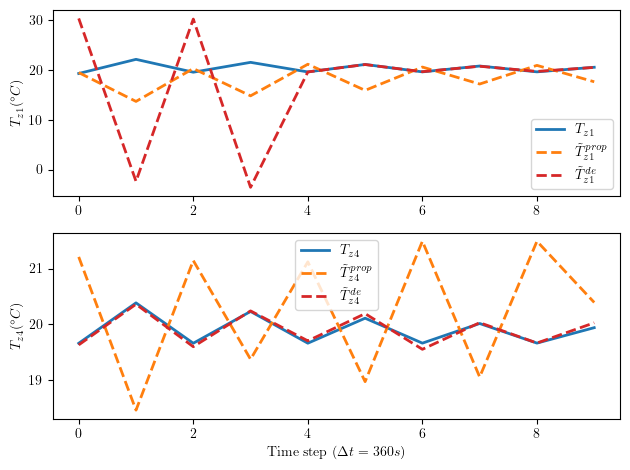

In [17]:
# plotting
time_step = np.arange(K)


mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')

fig, ax = plt.subplots(2, 1)


ax[0].plot(time_step, y_output[0,:], lw=2, label=r'$T_{z1}$', c='tab:blue')
ax[0].plot(time_step, y_tilde_output_proposed[0,:], '--', lw=2, label=r'$\tilde{T}_{z1}^{prop}$', c='tab:orange')
ax[0].plot(time_step, y_tilde_output_diff[0,:], '--', lw=2, label=r'$\tilde{T}_{z1}^{de}$', c='tab:red')


ax[1].plot(time_step, y_output[1,:], lw=2, label=r'$T_{z4}$', c='tab:blue')
ax[1].plot(time_step, y_tilde_output_proposed[1,:], '--', lw=2, label=r'$\tilde{T}_{z4}^{prop}$', c='tab:orange')
ax[1].plot(time_step, y_tilde_output_diff[1,:], '--', lw=2, label=r'$\tilde{T}_{z4}^{de}$', c='tab:red')



# ax[0].set(ylabel='Temp',ylim=(14,20))
ax[0].set(ylabel=r'$T_{z1}(^{\circ}C)$')
ax[1].set(xlabel=r'Time step ($\Delta t=360s)$', ylabel=r'$T_{z4}(^{\circ}C)$')


ax[0].legend()
ax[1].legend()
plt.tight_layout()
fig.savefig("./pic/results.pdf", transparent=True)
fig.savefig("./pic/results.png", transparent=True, dpi=300)

/home/teimour/University/my_codes/IFAC_codes/venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


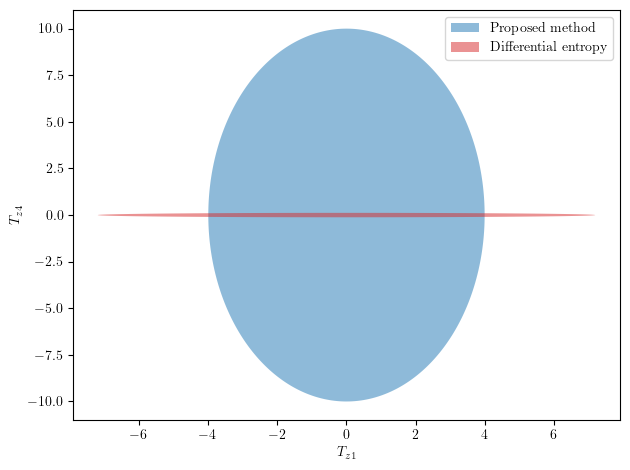

In [18]:
# plotting for the ellipsoids
T = 500
t = np.linspace(0, 2 * np.pi, T)
tx = np.cos(t).reshape(1, -1)
ty = np.sin(t).reshape(1, -1)
unit_circle = np.vstack((tx, ty))


# our confusion set
proposed_ellipse = np.diag([np.sqrt(sigma_v[0,0]), np.sqrt(sigma_v[3,3])]) @ unit_circle

# compared confusion set
sigma_v_diff_eig = LA.eig(sigma_v_diff, right=False)
diff_ellipse = np.diag([np.sqrt(sigma_v_diff_eig[0]), np.sqrt(sigma_v_diff_eig[3])]) @ unit_circle


# Set the font settings
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')


fig = plt.figure()
ax = fig.subplots(1,1)

ax.fill(proposed_ellipse[0, :], proposed_ellipse[1, :], alpha=0.5,  facecolor='tab:blue', label=r"Proposed method")
ax.fill(diff_ellipse[0, :], diff_ellipse[1, :], alpha=0.5,  facecolor='tab:red', label=r"Differential entropy")

# Set axis labels and limits
ax.set(xlabel=r"$T_{z1}$", ylabel=r"$T_{z4}$")
ax.legend()

plt.tight_layout()
fig.savefig("./pic/ellips.pdf", transparent=True)

fig.savefig("./pic/ellips.png", transparent=True, dpi=300)